In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import SMOTE

# Load dataset
df = pd.read_csv("Online Payments Fraud Detection Dataset.csv")
                  
# Drop duplicate rows
df.drop_duplicates(inplace=True)

# Handle missing values (optional, based on dataset inspection)
df.dropna(inplace=True)  # If there are too many missing values, fill with mean/median

# Encode categorical features
label_enc = LabelEncoder()
df['type'] = label_enc.fit_transform(df['type'])  # Encoding transaction type

# Drop ID columns if they don’t provide useful information
df.drop(columns=['nameOrig', 'nameDest'], inplace=True)  

# Ensure fraud cases are well-represented while reducing dataset size
df_fraud = df[df['isFraud'] == 1]  
df_non_fraud = df[df['isFraud'] == 0].sample(n=len(df_fraud) * 5, random_state=42)  # Adjust as needed
df = pd.concat([df_fraud, df_non_fraud])

# Scale numerical features
scaler = StandardScaler()
num_features = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']
df[num_features] = scaler.fit_transform(df[num_features])

# Reset index
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Balance the dataset using SMOTE (if dataset is still imbalanced)
X = df.drop(columns=['isFraud'])
y = df['isFraud']
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Convert back to DataFrame
df_resampled = pd.DataFrame(X_resampled, columns=X.columns)
df_resampled['isFraud'] = y_resampled

# Save the cleaned dataset
df_resampled.to_csv("cleaned_fraud_data.csv", index=False)
print("Preprocessing Completed. Data Saved as cleaned_fraud_data.csv")
 

Preprocessing Completed. Data Saved as cleaned_fraud_data.csv


In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Load cleaned dataset
df = pd.read_csv("cleaned_fraud_data.csv")

# Define features and target variable
X = df.drop(columns=["isFraud"])
y = df["isFraud"]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest model
rf_model = RandomForestClassifier(n_estimators=200, random_state=42)
rf_model.fit(X_train, y_train)

# Predictions
y_pred = rf_model.predict(X_test)

# Evaluation
print("Random Forest Performance:")
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

import joblib

# Save the Random Forest model
joblib.dump(rf_model, "fraud_detection_model.pkl")
print("Model Saved Successfully")



Random Forest Performance:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      8234
           1       0.99      1.00      1.00      8192

    accuracy                           1.00     16426
   macro avg       1.00      1.00      1.00     16426
weighted avg       1.00      1.00      1.00     16426

Accuracy: 0.9951905515645927
Model Saved Successfully


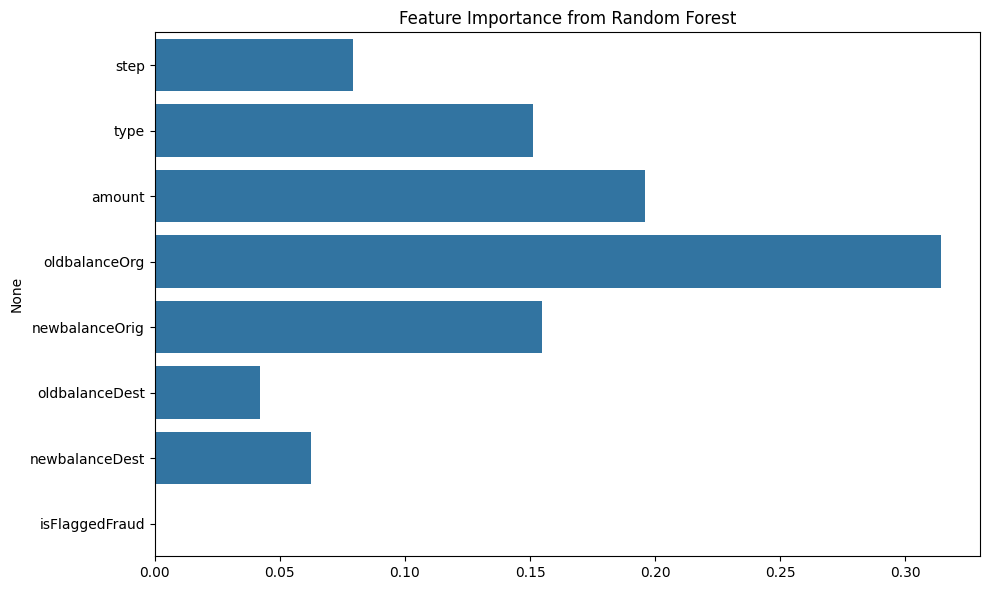

In [3]:
# Feature Importance
import matplotlib.pyplot as plt
import seaborn as sns

importances = rf_model.feature_importances_
features = X.columns

plt.figure(figsize=(10,6))
sns.barplot(x=importances, y=features)
plt.title("Feature Importance from Random Forest")
plt.tight_layout()
plt.show()


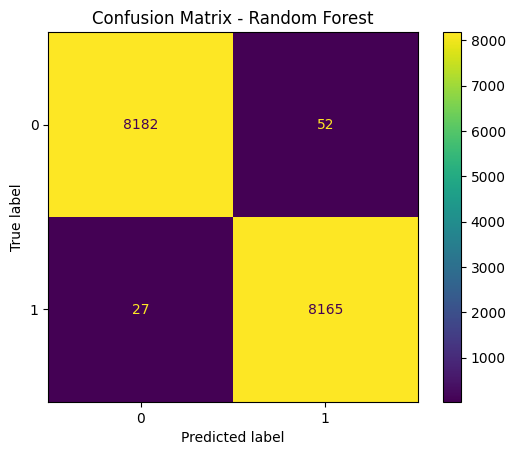

In [4]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_model.classes_)
disp.plot()
plt.title("Confusion Matrix - Random Forest")
plt.show()


In [5]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Reshape data for LSTM
X_train_reshaped = np.array(X_train).reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_reshaped = np.array(X_test).reshape((X_test.shape[0], X_test.shape[1], 1))

# Build LSTM Model
lstm_model = Sequential([
    LSTM(64, input_shape=(X_train_reshaped.shape[1], 1), return_sequences=True),
    Dropout(0.2),
    LSTM(32, return_sequences=False),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

# Compile model
lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train model
lstm_model.fit(X_train_reshaped, y_train, epochs=10, batch_size=32, validation_data=(X_test_reshaped, y_test))

# Evaluate model
lstm_predictions = (lstm_model.predict(X_test_reshaped) > 0.5).astype("int32")
print("LSTM Performance:")
print(classification_report(y_test, lstm_predictions))


c:\Users\Saxon sibi\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
2054/2054 ━━━━━━━━━━━━━━━━━━━━ 18s 7ms/step - accuracy: 0.7525 - loss: 0.4706 - val_accuracy: 0.8976 - val_loss: 0.2091
Epoch 2/10
2054/2054 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.8974 - loss: 0.2134 - val_accuracy: 0.9193 - val_loss: 0.1791
Epoch 3/10
2054/2054 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - accuracy: 0.9230 - loss: 0.1695 - val_accuracy: 0.9357 - val_loss: 0.1433
Epoch 4/10
2054/2054 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.9436 - loss: 0.1293 - val_accuracy: 0.9492 - val_loss: 0.1089
Epoch 5/10
2054/2054 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - accuracy: 0.9584 - loss: 0.1000 - val_accuracy: 0.9775 - val_loss: 0.0656
Epoch 6/10
2054/2054 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - accuracy: 0.9649 - loss: 0.0896 - val_accuracy: 0.9361 - val_loss: 0.1184
Epoch 7/10
2054/2054 ━━━━━━━━━━━━━━━━━━━━ 17s 8ms/step - accuracy: 0.9683 - loss: 0.0800 - val_accuracy: 0.9833 - val_loss: 0.0502
Epoch 8/10
2054/2054 ━━━━━━━━━━━━━━━━━━━━ 17s 8ms/step - accuracy: 0.9737 - loss: 0